Benchmarking of Variability of Energy Consumption Patterns
===========

## 2. Literature Review

Psiloglou et al. compare the variability of electricity load demand for Athens Greece, and London, UK in the temporal cycles of monthly, diurnal, and hourly, and proposed the corresponding the variation indexes (VI) [4].

## 3. The Dataset

The dataset used in our study includes the time series of electricity and water consumption, obtained from different geographic locations. All the data were produced by smart meters in every hour. 

** 3.1 Electricity consumption data **

* ESSEX data: 

* Australia open data [1]:

* Dataport open data [2]:

** 3.2 Water consumption data **

The water consumption data is from  Abbotsford  city, British Columnbia, Canada from September 1, 2012 to August 31, 2013. Daily and hourly time-series data were collected from 25,294 customers,  distributed in six customer groups (see Figure 1). There are 2013 215,172,496 data points in total for the hourly time-seriels data, and 9,232,310 data points for the daily time-series data (roughly 10GB in total). The residential customers are discriminated according to the house types, which are single family residential (SFRES) and multifamily residential (MFRES). As shown, the single family residential has the biggest share (79.61%).

![Distribution of users](waterdata.png)


## 4. Methodology

**4.1 Load patterns**

For an energy consumption time series, $X={x(t)}, t=1,...,N$, where each $x(t_i)$ is a measurement of the consumption at a given time interval, e.g., 15 min or 1 hour. For a given time window with $d$ time slots, a vector is created for the measures with $d$ dimensions, i.e., $X_i=\{x(t_{i+1}), ..., x(t_{i+d}) \}$. The time series $X$ thus can be represented as $\{X_1, X_2, X_3, ... \}$, which are the load patterns (or shapes) with a fixed-length time window. We normalize the load pattern of a time window(e.g., the $i$-th) as the following:

\begin{equation}
	s_i(t) = \frac{x_i(t)}{S_i}
\end{equation}
where $S_i$ is the total consumption in this window. Thus, $\sum_{t=1}^d s_i(t)=1$. In the following, we use the normalized load  patterns for our studies.

**4.2 Clustering load patterns**

We cluster the input load patterns $S=\{s(t)\}, t\in 1, ..., D$ using K-means clustering algorithm (in this case we cluster daily load patterns). The K-means algorithm is an iterative process to find a local optimal solution to a problem. In other words, its objective is to find


\begin{equation}
\underset{S}{\operatorname{argmin}} \sum_{i=1}^k \sum_{s\in S_i} d(s, c_i)^2
\end{equation}
where $d(x, c_i)$ is the distance between the vector $x$ and the centroid $c_i$. In clustering the most frequently used distance metric is the Euclidean distance between two points, $x$ and $y$, $d=||x-y||_2=\sqrt{\sum_{i=1}^n(x_i-y_i)^2}$. The Euclidean distance, however, has the drawback for understanding the information of the shapes of energy consumption [3]. In this study, we make use of the distance metric offered by the {\em K-Spectral Centroids (KSC)} algorithm [5], called _KSC distance_, which is defined as
\begin{equation}
\hat{d}(x, y) = \underset{\alpha,q}{\operatorname{min}}\frac{||x-\alpha y_q||}{||x||}
\end{equation}
where $\alpha$ is a scaling factor and $y_q$ is a shifted version of $y$ by the amount $q$ that minimizes the instance. In our implementation, we shit the $q$ between $-2$ and $2$, \ie, the last two hours of the previous day and the first two hours of the next day. We compute the distance iteratively for the 4 shifts, and use the minimal one as the distance. Since we use the normalized values to compute the distance, we simply take $\alpha$ value as 1. With this KSC distance metric, a cluster centroid is computed.


In clustering, there are several methods to determinate the appropriate number of clusters, $K$, and a number of measures for measuring the clustering performance. In our implementation, we determinate the $K$ value by a variance coverage method, \ie, 

\begin{equation}
Coverage = \frac{SS_B}{SS_T}
\end{equation}
where $SS_B$ is the  overall between-cluster variance, while $SS_T$ is the total variance to the overall mean.

$SS_B$ is defined as 

\begin{equation}
SS_B = \sum_{i=1}^k n_i||\mu_i - \mu||
\end{equation}

where $\mu_i$ is the centroid of the $i$th cluster, $\mu$ is the overall mean of the sample data (the daily patterns). $SS_T$ is defined as 

\begin{equation}
SS_T = \sum_{i=1}^N ||x_i - \mu||
\end{equation}

where $x_i$ is the data point in the smaple data, $\mu$ is the overall mean of the sample data. With a given variance coverage value, the clustering program stop when it satisfy the goal, and exists with the found $K$ clusters.


**4.3 Computing the variability (or stability)**

We evaluate the variability (or conversely stability) of user energy consumption by computing the entropy over all daily load profiles. The entropy is a logarithmic measure of the number of states with significant probability of being occupied, i.e.,

\begin{equation}
S = -\sum_i p_i ln p_i
\end{equation}

The higher value of $S$ means more unpredictable consumption of the use may have. Therefore, a threshold value can be set to classify the users predictable and unpredictable. We compute the probability according to the frequencies of load patterns classified into each of the cluster, i.e., 

\begin{equation}
p_i = \frac{D_{c_i}}{D}
\end{equation}

where $D_{c_i}$ is the number of days whose load patterns are classified into the cluster $C_i$, and $D$ is the total number of days.

## 5. Results and Discussion

In this experiment, we set the $coverage=0.5$, and the algorithm discovers 16 clusters. We compute the entropy for each customer, and make the histogram to show the entropy distribution

In [134]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd


def plot_centroids(file_name, n_rows, n_cols, y_lim):
    fig, axs= plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(8,8), sharey=True)
    data = pd.read_csv(file_name,sep='|', names=['centroidID','share', 'centroid'])    
    data.sort_values('share',ascending=False, inplace=True)
    centroids = data.centroid.get_values()
    shares = data.share.get_values()

    i = 0
    for r in range(len(axs)):
        for c in range(len(axs[0])):
            if i<len(centroids):
                axs[r][c].set_xlim([0, 23])
                axs[r][c].set_ylim([0, y_lim])

                axs[r][c].set_xlabel('C'+ str(1+i) + ": %.1f" % shares[i] + '%')
                axs[r][0].set_ylabel('Nomalized consumption')
                axs[r][c].plot(range(24), map(float, centroids[i].split(',')))
                i = i +1
    plt.tight_layout()


def plot_entropy(file_name):
    data = pd.read_csv(file_name,sep='|', names=['meterid','entropy'])
    fig, axs= plt.subplots(nrows=1, ncols=1, figsize=(4,4), sharey=True)
    axs.set_xlabel('Entropy')
    axs.set_ylabel('Number of households')
    axs.hist(data.entropy, alpha=0.5)   

### 5.1 Australia Electricity data

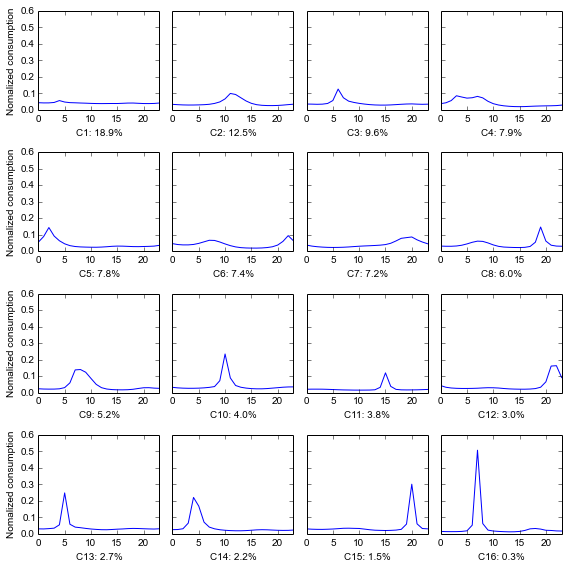

In [113]:
plot_centroids("au_centroid.csv", 4, 4, 0.6)

Histogram of entropy:

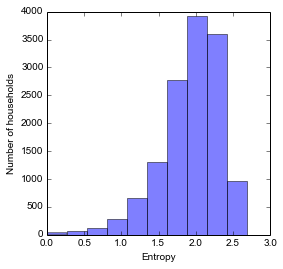

In [127]:
plot_entropy('au_entropy.csv')

### 2. Canada Residential Electricity Consumption Data (ESSEX)

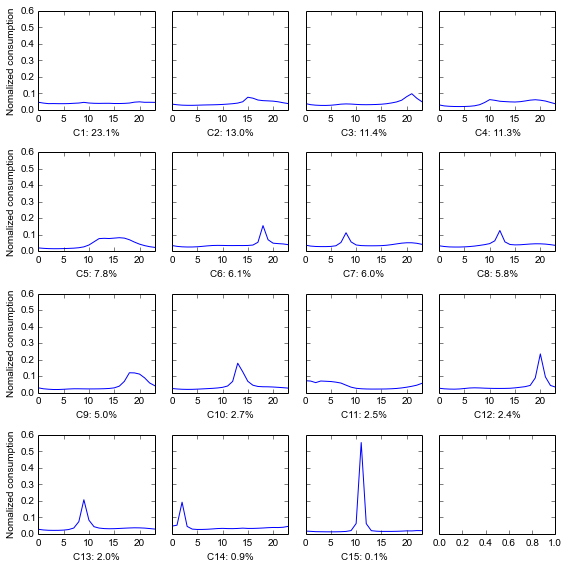

In [111]:
plot_centroids("essex_centroid.csv", 4, 4, 0.6)

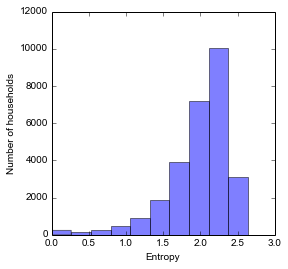

In [129]:
plot_entropy('essex_entropy.csv')

### 3. Residential Electricity Data in Austin, USA (Dataport)

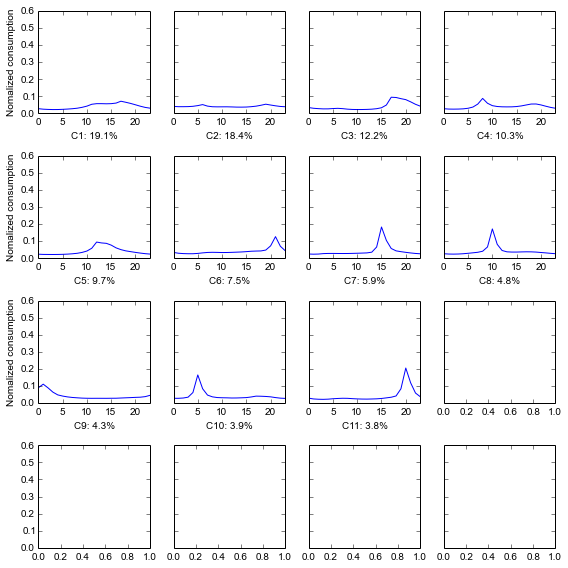

In [112]:
plot_centroids("dataport_centroid.csv", 4, 4, 0.6)

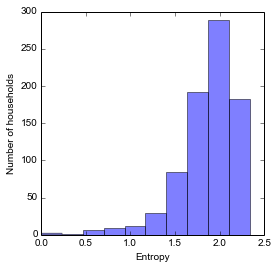

In [130]:
plot_entropy('dataport_entropy.csv')

### 4. Water Data (Canada)

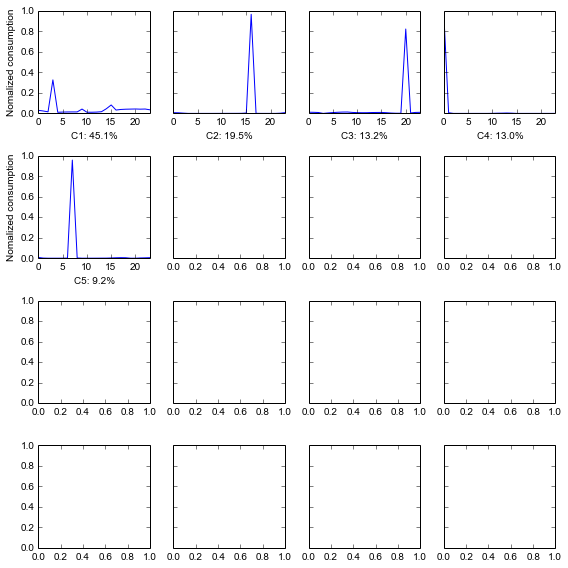

In [140]:
plot_centroids("water_centroids.csv", 4, 4, 1.0)

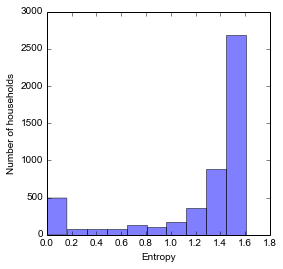

In [131]:
plot_entropy('water_entropy.csv')

### References

_1.Smart-Grid Smart-City Customer Trial Data. https://data.gov.au/dataset/smart-grid-smart-city-customer-trial-data/ as of 2016-06-06._ 

_2. Dataport. https://dataport.pecanstreet.org/ as of 2016-06-06._

_3. Albert A, Gebru T, Ku J, Kwac J, Leskovec J, Rajagopal R.  Drivers of variability in energy consumption. Proc. of ECML-PKDD DARE Workshop on Energy Analytics 2013._

_4. Psiloglou BE, Giannakopoulos C, Majithia S,  Petrakis M.  Factors affecting electricity demand in Athens, Greece and London, UK: A comparative assessment. Energy 2009, 34(11):1855-1863._

_5. Yang J, Leskovec J. Patterns of temporal variation in online media. In Proc. of the 4th ACM international conference on Web search and data mining, pp. 177-186, 2011._
